1. На основе учебного ноутбука проведите финальную подготовку данных. Измените количество сегментирующих классов с `16` на `7`:
  - 0_класс - FLOOR
  - 1_класс - CEILING
  - 2_класс - WALL
  - 3_класс - APERTURE, DOOR, WINDOW
  - 4_класс - COLUMN, RAILINGS, LADDER
  - 5_класс - INVENTORY
  - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Изучите внимательно особенности `U-net`, определите в чем принципиальное отличие  `U-net `  и   `simpleUnet` из учебного ноутбука.

3. Доработайте `simpleUnet` с учетом особенностей `U-net `. Обучите модель на 100 эпохах и визуализируйте результат.

**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

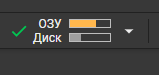

Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [11]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
# import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [12]:
# Загрузка датасета из облака

# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

# !unzip -q 'construction_256x192.zip' # распоковываем архив

### Предварительная подготовка данных


In [13]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT =  192            # Высота картинки
NUM_CLASSES = 7              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [14]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_HEIGHT, IMG_WIDTH)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_HEIGHT, IMG_WIDTH)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 18.82c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 1.03c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [15]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_HEIGHT, IMG_WIDTH)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_HEIGHT, IMG_WIDTH)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 19.8c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 1.04c
Количество изображений:  100


## Решение

In [ ]:
# Ваше решение
CLASS_LABELS_16 = (
    (100, 100, 100),
    (0, 0, 100),
    (0, 100, 0),
    (100, 0, 0),
    (0, 100, 100),
    (100, 0, 100),
    (100, 100, 0),
    (200, 200, 200),
    (0, 200, 0),
    (200, 0, 0),
    (0, 200, 200),
    (0, 0, 200),
    (200, 0, 200),
    (200, 200, 0),
    (0, 100, 200),
    (100, 0, 200),
)
LABELS_7_CLASS = (0, 1, 2, 4, 3, 3, 3, 6, 4, 6, 6, 4, 5, 6, 6, 6)
FLOOR_COLOR = (100, 100, 100)
CEILING_COLOR = (0, 0, 100)
WALL_COLOR = (0, 100, 0)
APERTURE_DOOR_WINDOW_COLOR = (0, 100, 100)
COLUMN_RAILINGS_LADDER_COLOR = (100, 0, 0)
INVENTORY_COLOR = (200, 0, 200)
MISC_COLOR = (200, 200, 200)

CLASS_LABELS_7 = (
    FLOOR_COLOR,
    CEILING_COLOR,
    WALL_COLOR,
    APERTURE_DOOR_WINDOW_COLOR,
    COLUMN_RAILINGS_LADDER_COLOR,
    INVENTORY_COLOR,
    MISC_COLOR,
)

In [ ]:
def rgb_to_labels_7(
    image_list, class_labels=CLASS_LABELS_16, new_labels=CLASS_LABELS_7
):
    result = []
    for d in image_list:

        sample = np.array(d)
        y = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype="uint8")
        
        for i, cl in enumerate(class_labels):
            y[np.where(np.all(sample == class_labels[i], axis=-1))] = new_labels[i]
        result.append(y)
    return np.array(result)


def labels_7_to_rgb(image_list):
    result = []
    for y in image_list:
        temp = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype="uint8")
        for i, cl in enumerate(CLASS_LABELS_7):
            temp[np.where(np.all(y == i, axis=-1))] = CLASS_LABELS_7[i]
        result.append(temp)
    return np.array(result)


In [ ]:
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])

y_train = rgb_to_labels_7(train_segments, CLASS_LABELS_16, LABELS_7_CLASS)
y_val = rgb_to_labels_7(val_segments, CLASS_LABELS_16, LABELS_7_CLASS)

print("Форма x_train:", x_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_val:", y_val.shape)


Форма x_train: (1900, 192, 256, 3)
Форма x_val: (100, 192, 256, 3)
Форма y_train: (1900, 192, 256, 1)
Форма y_val: (100, 192, 256, 1)


In [48]:
def process_images(model, count=1):
    indexes = np.random.randint(0, len(x_val), count)
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)
    orig = labels_7_to_rgb(predict[..., None])

    fig, axs = plt.subplots(3, count, figsize=(25, 15))

    if count == 1:
        axs[0].set_title("Результат работы модели:")
        axs[0].imshow(orig[0])
        axs[0].axis("off")

        axs[1].set_title("Оригинальное сегментированное")
        axs[1].imshow(val_segments[indexes[0]])
        axs[1].axis("off")

        axs[2].set_title("Оригинальное изображение")
        axs[2].imshow(val_images[indexes[0]])
        axs[2].axis("off")
    else:
        for i in range(count):
            axs[0, 0].set_title("Результат работы модели:")
            axs[0, i].imshow(orig[i])
            axs[0, i].axis("off")

            axs[1, 0].set_title("Оригинальное сегментированное")
            axs[1, i].imshow(val_segments[indexes[i]])
            axs[1, i].axis("off")

            axs[2, 0].set_title("Оригинальное изображение")
            axs[2, i].imshow(val_images[indexes[i]])
            axs[2, i].axis("off")
    plt.show()

In [20]:
def masked_unet(
    CLASS_COUNT, input_shape, filters=64, kernel_size=(3, 3), activation="relu"
):
    img_input = Input(input_shape)

    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(filters * 16, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 16, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)


    x = Conv2DTranspose(
        filters * 8, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_4])  # Skip connection
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 8, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(
        filters * 4, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_3])  # Skip connection
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 4, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(
        filters * 2, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_2])  # Skip connection
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters * 2, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(
        filters, kernel_size, strides=(2, 2), padding="same", activation=activation
    )(x)
    x = BatchNormalization()(x)
    x = concatenate([x, x_1])  # Skip connection
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding="same", activation=activation)(x)
    x = BatchNormalization()(x)

    x = Conv2D(CLASS_COUNT, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    model = Model(img_input, x)
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


In [21]:
model_unet_7_classes = masked_unet(NUM_CLASSES, (IMG_HEIGHT, IMG_WIDTH, 3))
model_unet_7_classes.summary()


I0000 00:00:1748205196.547937     669 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78670 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:0f:00.0, compute capability: 9.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 192, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 192, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 128,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 128,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 128,   │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 128,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 48, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 48, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 64,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 24, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 24, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 34,541,127 (131.76 MB)

 Trainable params: 34,527,431 (131.71 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [22]:
history = model_unet_7_classes.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(x_val, y_val),
    verbose=1,
)


Epoch 1/100


I0000 00:00:1748205207.031790    2127 service.cc:148] XLA service 0x7fd90405a500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748205207.031818    2127 service.cc:156]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-05-25 20:33:27.238146: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1748205207.729943    2127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1748205208.300130    2127 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-25 20:33:44.661557: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA

  3/119 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2.4256 - sparse_categorical_accuracy: 0.1716  

2025-05-25 20:33:48.651936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 1784 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1748205228.708086    2127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/119 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.5589 - sparse_categorical_accuracy: 0.4930

W0000 00:00:1748205234.212518    2126 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - loss: 1.5538 - sparse_categorical_accuracy: 0.4947

W0000 00:00:1748205252.840621    2126 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748205255.128235    2127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


119/119 ━━━━━━━━━━━━━━━━━━━━ 58s 242ms/step - loss: 1.5514 - sparse_categorical_accuracy: 0.4955 - val_loss: 290.6402 - val_sparse_categorical_accuracy: 0.2045
Epoch 2/100
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.9481 - sparse_categorical_accuracy: 0.6863 - val_loss: 2.7930 - val_sparse_categorical_accuracy: 0.5235
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.8414 - sparse_categorical_accuracy: 0.7227 - val_loss: 3.3002 - val_sparse_categorical_accuracy: 0.4124
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.8221 - sparse_categorical_accuracy: 0.7276 - val_loss: 1.4227 - val_sparse_categorical_accuracy: 0.6049
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.8000 - sparse_categorical_accuracy: 0.7362 - val_loss: 1.1404 - val_sparse_categorical_accuracy: 0.6403
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.7088 - sparse_categorical_accuracy: 0.7642 - val_loss: 1.1754 - val_sparse_categorical_accur

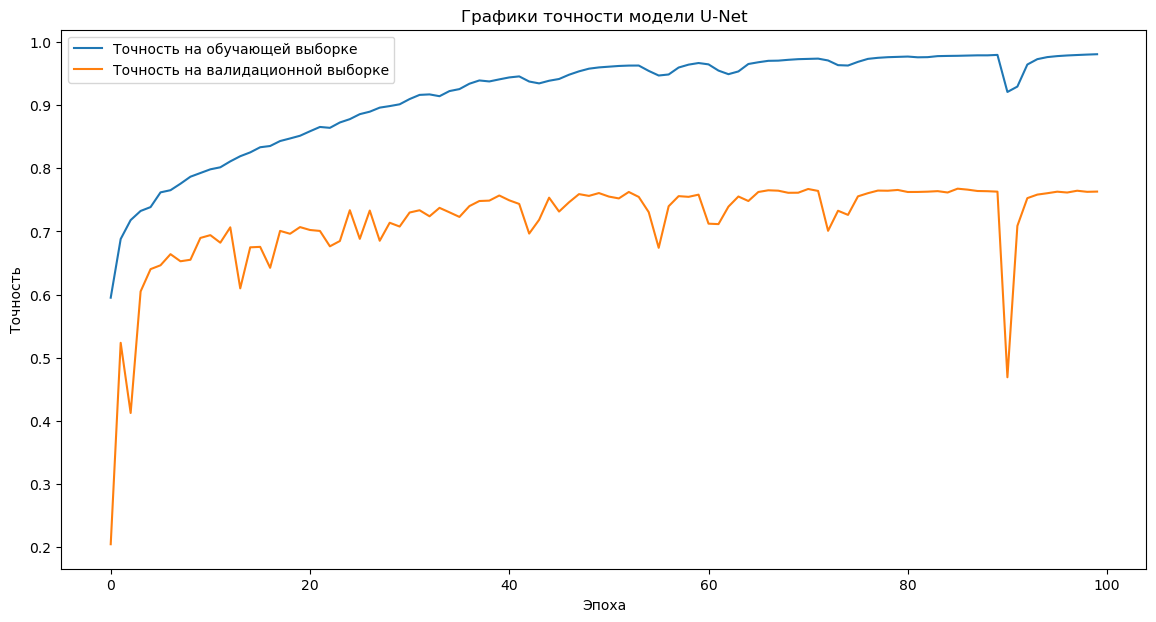

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(
    history.history["sparse_categorical_accuracy"],
    label="Точность на обучающей выборке",
)
plt.plot(
    history.history["val_sparse_categorical_accuracy"],
    label="Точность на валидационной выборке",
)
plt.title("Графики точности модели U-Net")
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


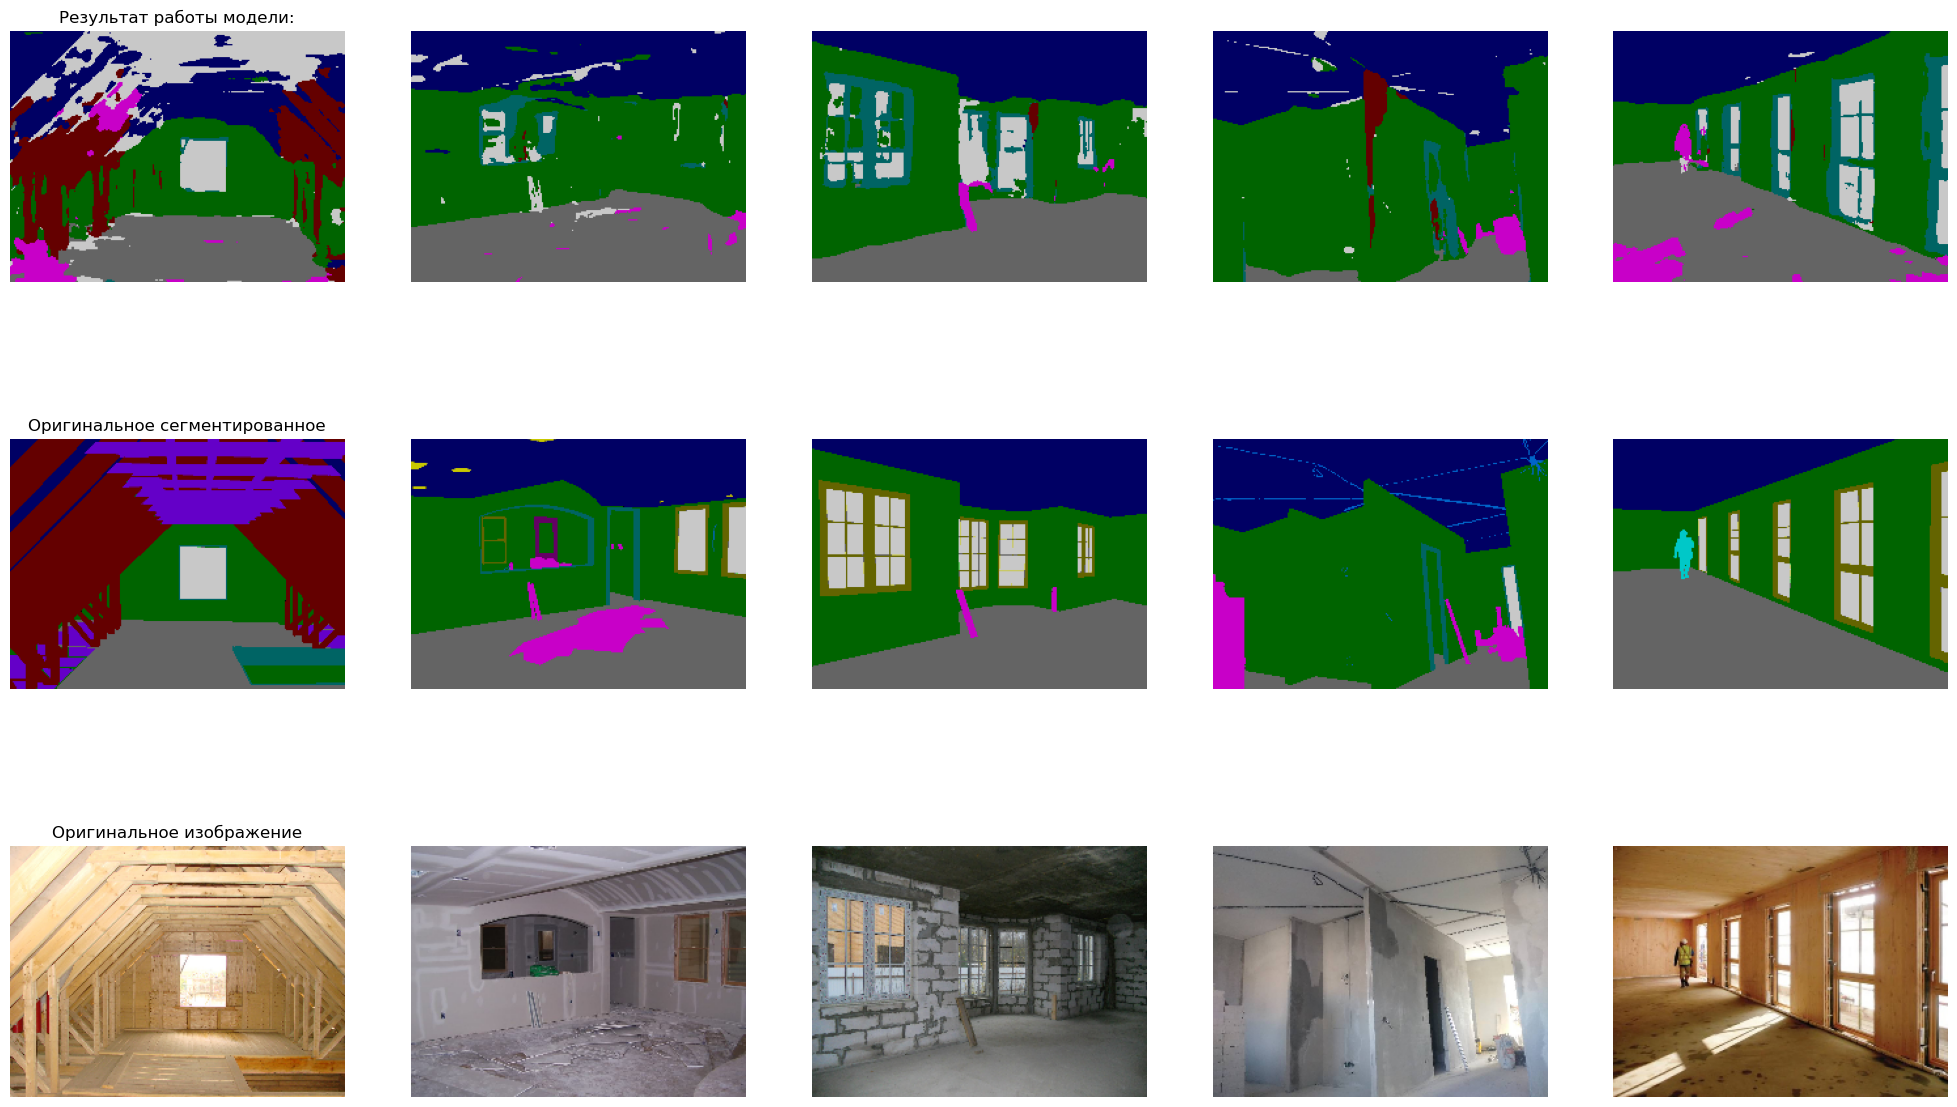

In [54]:
process_images(model_unet_7_classes, 5)